In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import re
import pandas as pd
from plotting_utils import x_labeling

In [2]:
# Colors
colors = {'price_taker_dispatch_time': '#DE3163', 'price_maker_dispatch_time': '#00008B', 
          'price_taker_residence_time': '#f091ac', 'price_maker_residence_time': '#9c9cea',
          'price_taker_ligh': '#f091ac', 'price_taker_dark': '#c0063b'}

# Font
font_path = 'Helvetica.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica'

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
        btes_investment += component_results[component_results.index == comp]['Operational Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        time_inputs = data['time inputs']
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return time_inputs, case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_dispatch_time(case, plot_df_maker, plot_df_taker, xlabel, ylabel):
    """
    Plot bar chart for price maker and price taker
    """
    fig, ax = plt.subplots()

    for var in ['dispatch_time', 'residence_time']:
        for run in ['price_maker', 'price_taker']:
            res_df = plot_df_taker if run == 'price_taker' else plot_df_maker
            ax.plot(res_df['cost_factor_float']*100, res_df[var], 'o', color=colors[run+'_'+var], label=run+' '+var.replace('_',' '))
            ax.plot(res_df['cost_factor_float']*100, res_df[var], color=colors[run+'_'+var], label=run+' '+var.replace('_',' '))

    # Log scale y-axis
    ax.set_yscale('log')
    ax.set_ylim(0.1, 1000)
    ax.set_yticks([0.1, 1, 10, 100, 1000])
    ax.set_yticklabels(['0.1', '1', '10', '100', '1000'], fontsize=15)

    if 'BTES' in xlabel: 
        xlabel = xlabel.replace('BTES', 'underground thermal storage')
    ax.set_xlabel(xlabel.replace('_',' '), fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

    x_labeling(ax, case, res_df['cost_factor_float']*100, fontsize=15)
    # Only set lower x-axis bound
    ax.set_xlim(left=0)

    # Make only the 100% tick bold
    fig.canvas.draw()
    for label in ax.get_xticklabels():
        if label.get_text() == '100%':
            label.set_fontweight('bold')

    fig.savefig(f'figures/btes_dispatch_time_{case}.pdf', bbox_inches='tight', dpi=500)


In [6]:
def plot_energy_in_store(case, var, var2, xlabel, ylabel, ylabel2, color, linestyle, label, fig=None, ax=None):
    """
    Plot curve for price maker and price taker.
    If fig and ax are provided, adds lines to the existing plot; otherwise, creates a new plot.
    """
    # If no figure and axes are provided, create a new plot
    if fig is None and ax is None:
        save = False
        fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        ax[0].set_ylabel(ylabel, fontsize=14)
        ax[1].set_xlabel(xlabel, fontsize=14)
        ax[1].set_ylabel(ylabel2, fontsize=14)
        ax[0].tick_params(axis='x', labelsize=12)
        ax[0].tick_params(axis='y', labelsize=12)
        ax[1].tick_params(axis='x', labelsize=12, rotation=45)
    else:
        save = True

    # Plot data
    ax[0].plot(var, label=label, color=color, linestyle=linestyle)
    ax[0].set_xlim(var.index[0], var.index[-1])
    ax[0].set_ylim(0, 2500)
    ax[0].legend(loc='upper right', fontsize=10, frameon=False)
    if var2 is not None:
        ax[1].plot(var2, label=label, color='black', linewidth=0.5)
        ax[1].set_yscale('log')
        # replace 10^1 with 10 etc
        ax[1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    if save:
        plt.savefig(f'figures/btes_energy_in_store_taker_{case}.pdf', bbox_inches='tight')

    return fig, ax  # Return fig and ax to reuse in the loop


In [7]:
# Plot capacity for maker
def plot_capacity(maker_results_df, case):
    fig, ax = plt.subplots()

    # Normalize with mean demand
    with open('output_data/btes_base_case_orca/btes_output_BTES_costsx1e-06.pickle', 'rb') as f:
        data = pickle.load(f)
    mean_demand = data['time results']['load load'].mean()

    # Divide by mean demand
    maker_results_df['capacity'] = maker_results_df['capacity'] / mean_demand
    maker_results_df['capacity_store'] = maker_results_df['capacity_store'] / mean_demand

    # Set 0 values to NaN
    maker_results_df['capacity'] = maker_results_df['capacity'].replace(0, np.nan)
    maker_results_df['capacity_store'] = maker_results_df['capacity_store'].replace(0, np.nan)

    # Double y-axis
    ax2 = ax.twinx()

    # Power capacity
    ax.plot(maker_results_df['cost_factor_float']*100, maker_results_df['capacity'], color='navy',
            linestyle=':', marker='o', label='Power capacity')
    ax.tick_params(axis='y', labelcolor='navy')
    ax.set_xlim(left=0)
    ax.set_ylim(0, 3)
    # Tick labels integers but tick marks also in between
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    # Energy capacity
    ax2.plot(maker_results_df['cost_factor_float']*100, maker_results_df['capacity_store'], color='dodgerblue', 
             linestyle='-', marker='o', markerfacecolor='none', label='Energy capacity')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')
    ax.set_xlabel('of current {0} costs'.format(case.replace('_',' ') if case!='BTES' else 'underground thermal storage'), fontsize=18)
    ax.set_ylabel('Discharge capacity\nper mean demand [MW/MW]', color='navy', fontsize=18)
    ax2.set_ylabel('Energy capacity\nper mean demand [MWh/MW]', color='dodgerblue', fontsize=18)
    ax2.set_ylim(0, 3000.)

    # Axis tick labels size
    ax2.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    ax = x_labeling(ax, case, maker_results_df['cost_factor_float']*100, fontsize=15)

    # Save figure
    plt.savefig('figures/btes_capacity_maker_{0}.pdf'.format(case), bbox_inches='tight')

In [8]:
def collect_data(data_path_maker, data_path_taker, prices, case):
    """
    Create price maker and price taker plots
    """
    # Collect results
    dispatch_time = {'price_maker': [], 'price_taker': []}
    residence_time = {'price_maker': [], 'price_taker': []}
    capacity = {'price_maker': [], 'price_taker': []}
    capacity_store = {'price_maker': [], 'price_taker': []}
    gen_capacity = {'price_maker': [], 'price_taker': []}

    # Loop over prices in descending order
    for run in ['maker', 'taker']:
        figure, axis = None, None

        # Get results
        for price in prices:
            result_file = data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price))
            time_input, case_res, comp_res, time_res, btes_cost = read_output_file(result_file)

            # Calculate dispatch_time
            granite = comp_res[comp_res.index == ('Store', 'granite')]
            discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
            
            granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
            discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
            dur = granite_opt_cap / discharger_opt_cap / 24 if discharger_opt_cap != 0 else np.nan

            # Add column to dataframe for dispatch time
            dispatch_time['price_'+run].append(dur)
            
            # Calculate mean "discharge time" as mean energy in store divided by mean discharge rate
            residence_time['price_'+run].append((time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean()) / 24
                                                if time_res['BTES_discharger dispatch'].mean() != 0 else np.nan)
            
            # Plot energy in store for price taker for values left and right of jump in dispatch time
            plot_factors_dict = {'BTES': ['0p74', '0p82'], 'fossil': ['1p32', '1p24']}
            if run == 'taker' and case in plot_factors_dict.keys() and price in plot_factors_dict[case]:
                # Mean demand
                mean_demand = time_res['load load'].mean()
                normalized_e_in_store = time_res['granite e'] / mean_demand / 24
                if price == plot_factors_dict[case][1]:
                    col = colors['price_taker_dark']
                    linestyle = '--'
                else:
                    col = colors['price_taker_light']
                    linestyle = '-'

                figure, axis = plot_energy_in_store(case, normalized_e_in_store, time_input['const_generator marginal cost'] if (price == plot_factors_dict[case][0] and run=='taker') else None,
                                    xlabel='Date', ylabel='Energy stored\n(days of mean demand)', ylabel2='Electricity cost\n[$/MWh]',
                                    color=col, linestyle=linestyle,label=price.replace('p','.')+' x current costs',
                                    fig=figure, ax=axis)
            
            # Add optimal capacity for all components
            capacity['price_'+run].append(discharger_opt_cap)
            capacity_store['price_'+run].append(granite_opt_cap)
            capacities = comp_res[~comp_res.index.get_level_values(0).isin(['Load', 'Store'])]['Optimal Capacity [MW]']
            
            # Drop level 0 of index
            capacities.index = capacities.index.droplevel(0)
            gen_capacity['price_'+run].append(capacities)

        # Store all in dataframe
        df = pd.DataFrame({'cost_factor': prices, 'cost_factor_float': [float(p.replace('p','.')) for p in prices], 
                           'dispatch_time': dispatch_time['price_'+run], 'residence_time': residence_time['price_'+run],
                            'capacity': capacity['price_'+run], 'capacity_store': capacity_store['price_'+run]})
        # Sort dataframe by cost_factor
        df = df.sort_values(by='cost_factor_float')

        if run == 'maker':
            price_maker_df = df
        else:
            price_taker_df = df

    return price_maker_df, price_taker_df

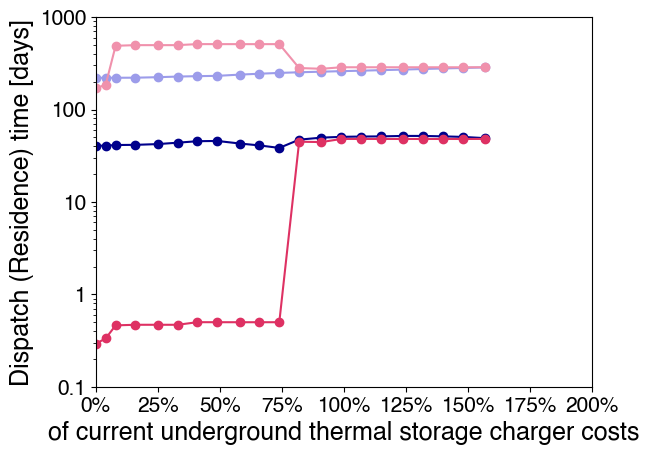

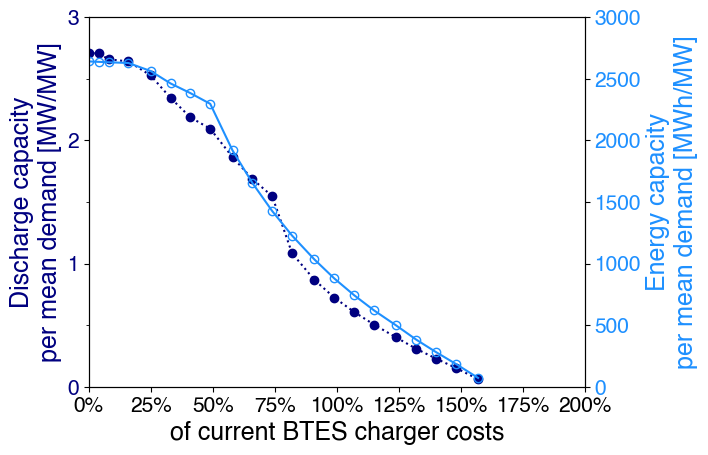

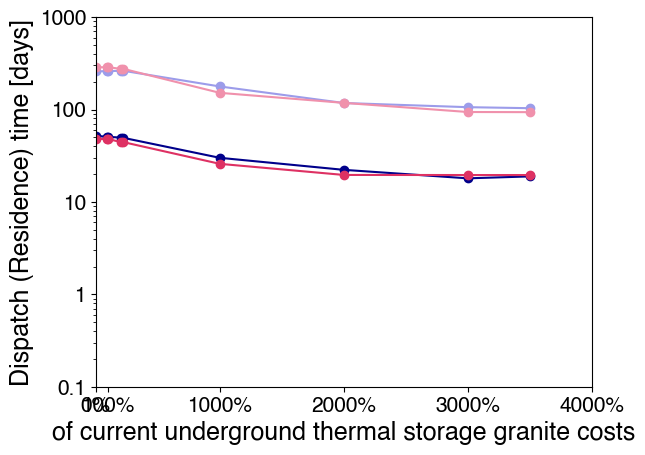

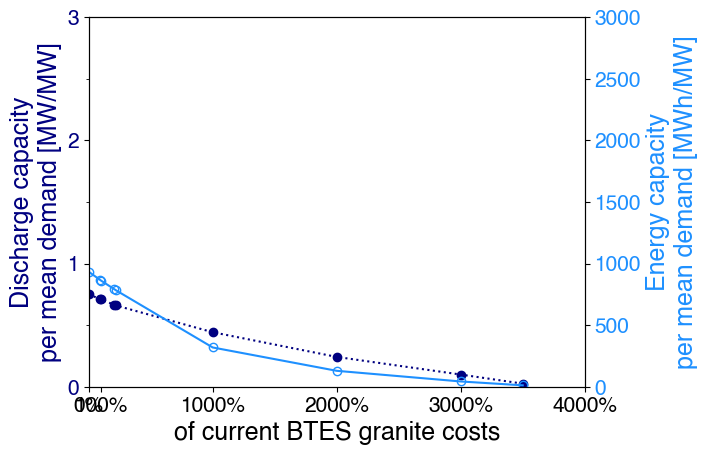

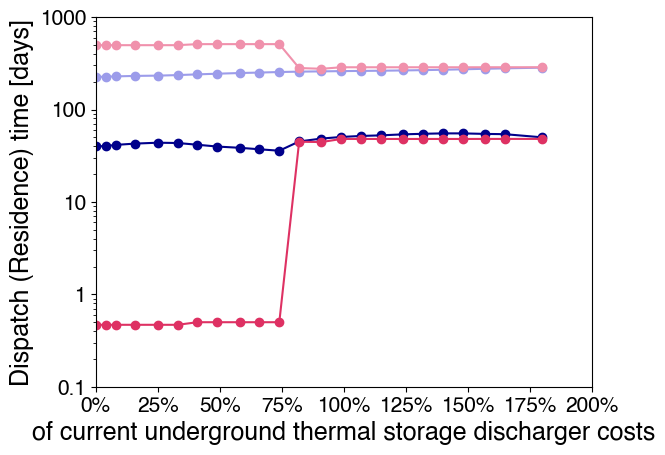

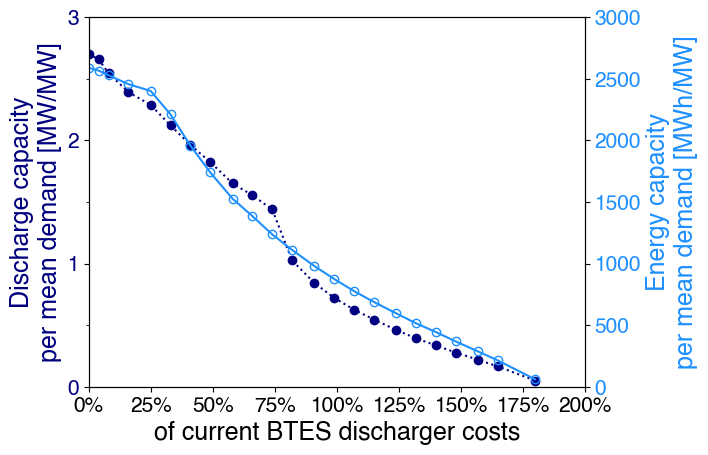

In [9]:
for case in ['BTES_charger', 'BTES_granite', 'BTES_discharger']:
    #['BTES', 'fossil', 'wind_solar', 'battery', 'hydrogen', 'BTES_charger', 'BTES_granite', 'BTES_discharger']:
    # Get all prices from file names      
    prices =  sorted({
    re.search(r'costsx([0-9]+p[0-9]+|[0-9]+e[-+]?[0-9]+)', f).group(1)
    for f in os.listdir('output_data/btes_base_case_orca') if f.endswith('.pickle') and case+'_costs' in f
    and f.replace('output','output_price_taker_base') in os.listdir('output_data/btes_base_case_orca_price_taker')})
    # Data paths
    data_path_taker = f'output_data/btes_base_case_orca_price_taker/btes_output_price_taker_base_{case}_costsx#COST.pickle'
    data_path_maker = f'output_data/btes_base_case_orca/btes_output_{case}_costsx#COST.pickle'

    # Collect data
    maker_df, taker_df = collect_data(data_path_maker, data_path_taker, prices, case)

    # Plot dispatch_time
    # Set values in price_taker to nan if they are nan in price_maker
    for var in ['dispatch_time', 'residence_time']:
        taker_df.loc[maker_df[var].isna(), var] = np.nan

    # Plot dispatch and residence time
    plot_dispatch_time(case, maker_df, taker_df, f'of current {case} costs', 'Dispatch (Residence) time [days]')
    # Plot energy and power capacity
    plot_capacity(maker_df, case)